## CSCN8030 - Artificial Intelligence for Business Decisions and Transformation
### Sprint 6 - Goodlife Fitness

Group 6:

Rohit Totlani - 8914803

Pradeepti Kasam - 8965985

Mohammed Benkhial -8928209

## A. Optimizing Group Fitness Class Utilization

GoodLife offers a range of fitness classes in two capacities - 25 and 15.
Some classes are always fully booked. Fully booked classes often have a low attendance rate.
GoodLife wants to increase the number of spaces available for classes.
They want to do this by predicting whether the member will attend the class or not.
If they can predict a member will not attend the class, they can make another space
available.

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

### Data Extraction

In [31]:
cu_df = pd.read_csv('problem2.csv')
cu_df.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


In [32]:
cu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


### Data Preprocessing

1. Finding & Handling Missing Values

In [33]:
cu_df.isnull().sum()

booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64

In [34]:
# Fill missing weights with 0
cu_df['weight'] = cu_df['weight'].fillna(cu_df['weight'].median())

2. Identifying and eliminating Duplicate rows

In [35]:
print("Number of duplicate rows :", cu_df.duplicated().sum())

Number of duplicate rows : 0


3. Handling inconsistent Data

In [36]:
cu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1500 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


In [37]:
cu_df['days_before'] = cu_df['days_before'].str.replace(' days', '').astype(int)

In [38]:
cu_df['day_of_week'] = cu_df['day_of_week'].str.replace('Fri.', 'Fri').str.replace('Monday', 'Mon').str.replace('Wednesday', 'Wed')

In [39]:
cu_df['category'] = cu_df['category'].str.replace('-', 'None')

### EDA

1. Distribution of attendance

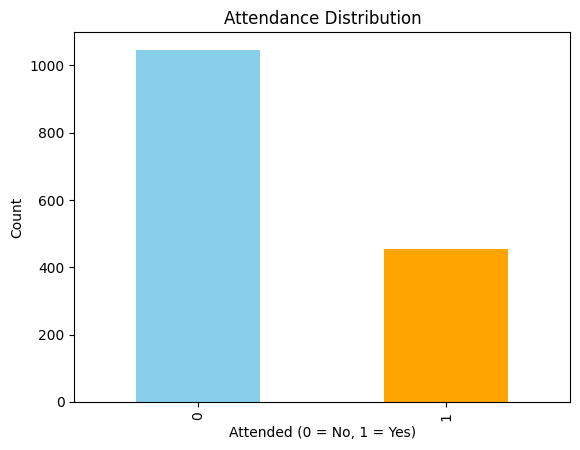

In [40]:
attendance_counts = cu_df['attended'].value_counts()
attendance_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Attendance Distribution')
plt.xlabel('Attended (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

The graph indicates a class imbalance, with a higher number of instances for class 0 (Not attended) compared to class 1 (Attended).

2. Distribution of weight

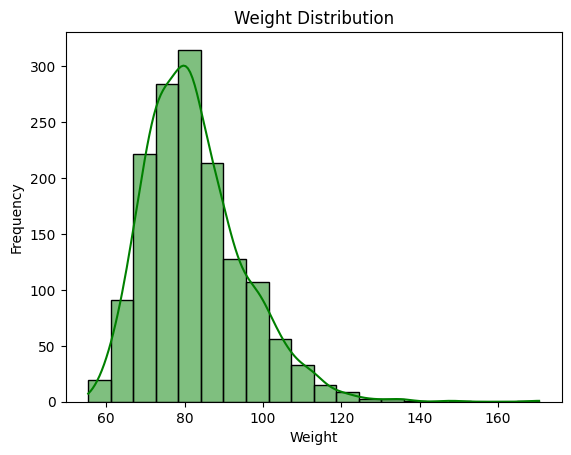

In [41]:
sns.histplot(cu_df['weight'], kde=True, bins=20, color='green')
plt.title('Weight Distribution')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

The histogram shows a right-skewed distribution of weight, with most values concentrated between 60 and 100 units.

3. Attendance by day of the week

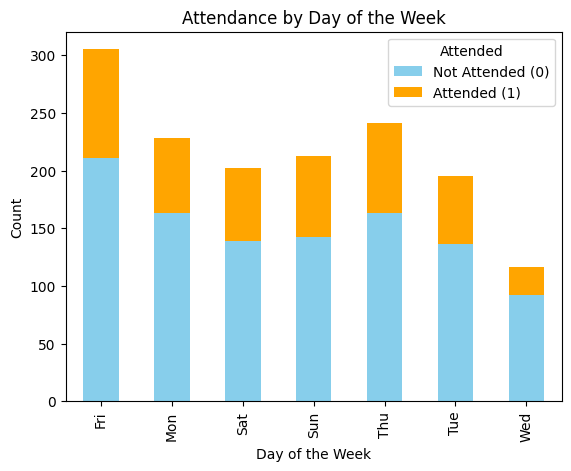

In [42]:
# Create a pivot table for stacking
pivot_table = cu_df.pivot_table(index='day_of_week', columns='attended', aggfunc='size', fill_value=0)

# Plot the stacked bar chart
pivot_table.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Attendance by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend(title='Attended', labels=['Not Attended (0)', 'Attended (1)'])
plt.show()

The chart shows that **Friday** had the **highest overall attendance**, while **Wednesday** had the **lowest**. Across all days, the count of those who did not attend (0) is consistently higher than those who did (1).

4. Attendance by category

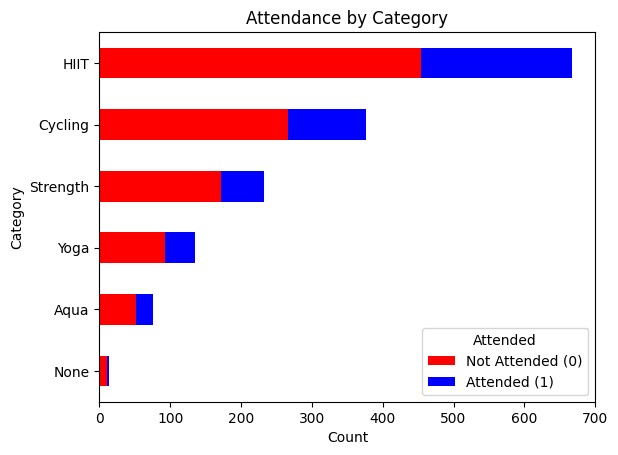

In [43]:
# Add a total column to sort by the total count
pivot_table = cu_df.pivot_table(index='category', columns='attended', aggfunc='size', fill_value=0)
pivot_table['Total'] = pivot_table.sum(axis=1)

# Sort the pivot table by the total count in descending order
pivot_table = pivot_table.sort_values(by='Total', ascending=True)

# Drop the 'Total' column after sorting
pivot_table = pivot_table.drop(columns='Total')

# Plot the stacked bar chart
pivot_table.plot(kind='barh', stacked=True, color=['Red', 'Blue'])
plt.title('Attendance by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.legend(title='Attended', labels=['Not Attended (0)', 'Attended (1)'])
plt.show()

The **HIIT** category had the highest participation and non-attendance overall, while Strength and Cycling also saw notable engagement. Attendance was generally lower across all categories compared to non-attendance.

5. Correlation heatmap

In [44]:
# Perform one-hot encoding on categorical variables
cu_df_encoded = pd.get_dummies(cu_df, columns=['day_of_week', 'time', 'category'])

# Display the first few rows of the encoded DataFrame
cu_df_encoded.head()

,booking_id,months_as_member,weight,days_before,attended,day_of_week_Fri,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,time_AM,time_PM,category_Aqua,category_Cycling,category_HIIT,category_None,category_Strength,category_Yoga
0,1,17,79.56,8,0,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False
1,2,10,79.01,2,0,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False
2,3,16,74.53,14,0,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False
3,4,5,86.12,10,0,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False
4,5,15,69.29,8,0,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False


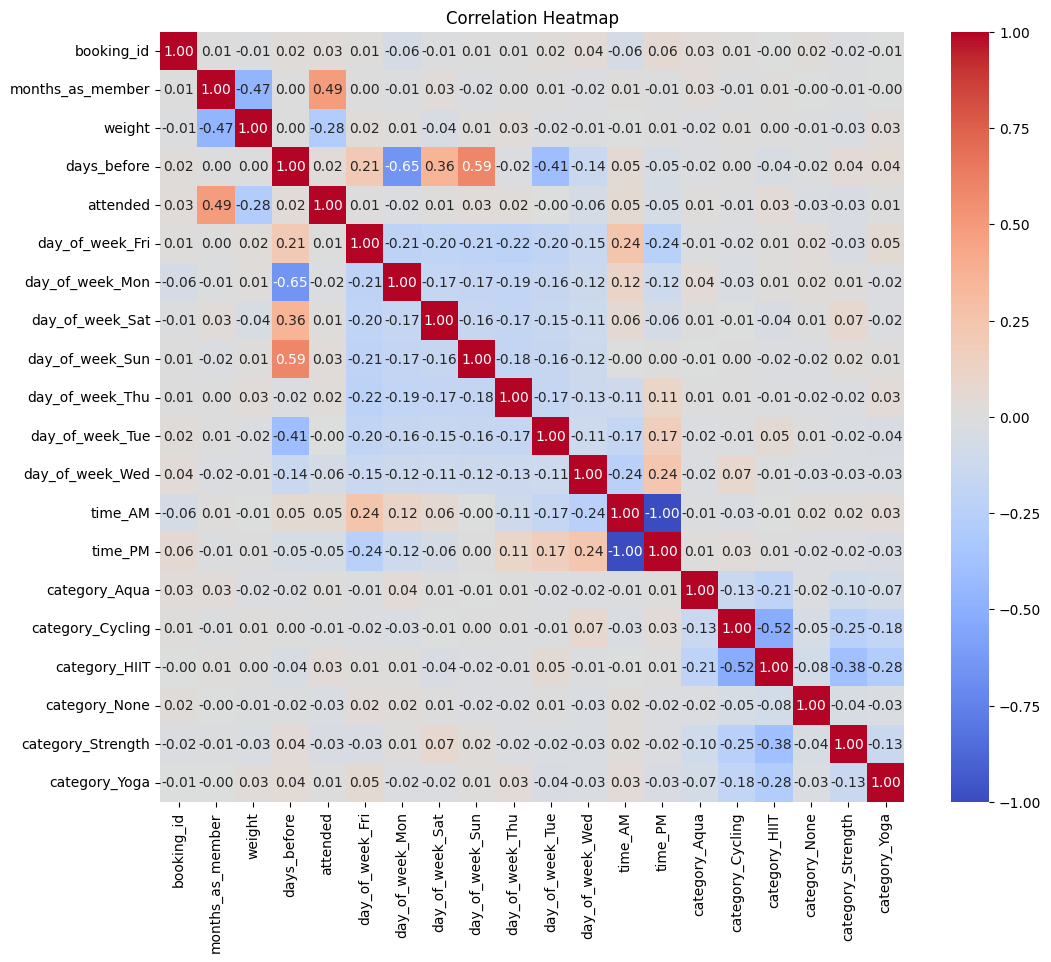

In [45]:
plt.figure(figsize=(12, 10)) 
correlation_matrix = cu_df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Strongest Positive Correlations:**

- attended vs months_as_member: 0.49 — moderate positive correlation; longer membership is slightly associated with higher attendance.

- days_before vs day_of_week_Sun: 0.59 — bookings made earlier might be more likely on Saturdays.

**Moderate Negative Correlations:**

- category_Cycling vs category_Strength: -0.25

- category_Cycling vs category_HIIT: -0.52 

- category_Strength vs category_HIIT: -0.38

- These indicate that users generally tend to prefer one category over another.


### Handling Class imbalance

A significant class imbalance is observed in the **attended** column, with 0 (Not attended) having 1046 instances and 1 (Attended) having 454 instances.

Applying **SMOTE (Synthetic Minority Oversampling Technique)** to address the class imbalance . This technique generates synthetic samples for the minority class to balance the dataset.

In [46]:
# Separate features and target variable
X = cu_df_encoded.drop('attended', axis=1)
y = cu_df_encoded['attended']

In [47]:
# Apply SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE again
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled features and target into a new DataFrame
resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['attended'])], axis=1)

# Display the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(resampled_df['attended'].value_counts())

Class distribution after SMOTE:
attended
0    1046
1    1046
Name: count, dtype: int64


In [48]:
# Number of rows and columns in the original dataset
print("Original dataset shape:", cu_df.shape)

# Number of rows and columns in the resampled dataset
print("Resampled dataset shape:", resampled_df.shape)

Original dataset shape: (1500, 8)
Resampled dataset shape: (2092, 20)


### Machine Learning Model

In [49]:
X = resampled_df.drop("attended", axis=1)
y = resampled_df["attended"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Logistic Regression**

In [50]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Update Logistic Regression with increased max_iter
model_LR = LogisticRegression(max_iter=500)
model_LR.fit(X_train_scaled, y_train)
y_pred_LR = model_LR.predict(X_test_scaled)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_LR))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       194
           1       0.92      0.75      0.83       225

    accuracy                           0.83       419
   macro avg       0.84      0.84      0.83       419
weighted avg       0.85      0.83      0.83       419



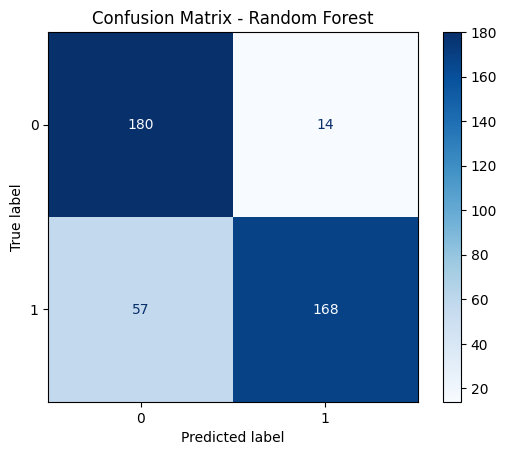

In [51]:
# Visualize confusion matrix for Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_LR, cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

**Random Forest**

In [52]:
model_rm = RandomForestClassifier()
model_rm.fit(X_train, y_train)

y_pred = model_rm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       194
           1       0.86      0.83      0.84       225

    accuracy                           0.84       419
   macro avg       0.83      0.84      0.83       419
weighted avg       0.84      0.84      0.84       419



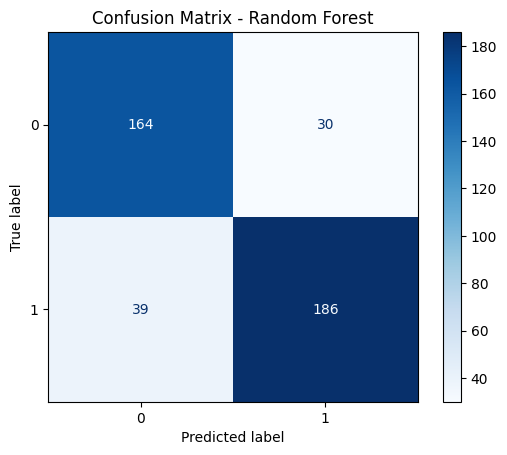

In [53]:
# Visualize confusion matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

**XGBoost**

In [54]:
# Train the XGBoost model without the deprecated parameter
model_xgb = XGBClassifier(eval_metric='logloss')
model_xgb.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Evaluate the model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       194
           1       0.88      0.84      0.86       225

    accuracy                           0.85       419
   macro avg       0.85      0.85      0.85       419
weighted avg       0.85      0.85      0.85       419



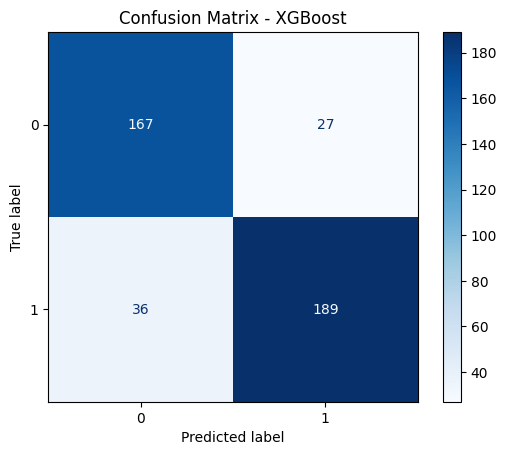

In [55]:
# Visualize confusion matrix for XGBoost
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.show()

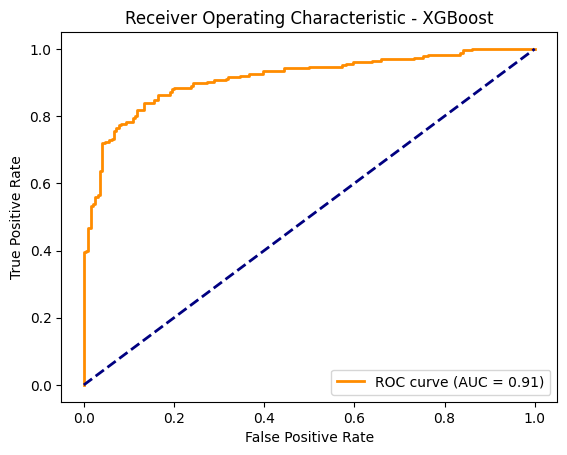

In [56]:
# Get the predicted probabilities for the positive class
y_pred_prob_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc='lower right')
plt.show()

AUC (Area Under the Curve) = 0.91

There's a 91% chance that the model ranks a randomly chosen attending member higher than a non-attending one.

### Conclusion

**XGBoost** demonstrated the best performance, achieving a balance between precision and recall, making it the most suitable model for predicting attendance. 

This predictive capability can help GoodLife optimize class utilization by identifying potential no-shows and opening up additional spots for other members, ultimately improving customer satisfaction and operational efficiency.